# Google Colab Setup 

Please run the code below to mount drive if you are running on colab.

Please ignore if you are running on your local machine.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/MiniGPT/

# Language Modeling and Transformers

The project will consist of two broad parts. 

1. **Baseline Generative Language Model**: We will train a simple Bigram language model on the text data. We will use this model to generate a mini story. 
2. **Implementing Mini GPT**: We will implement a mini version of the GPT model layer by layer and attempt to train it on the text data. You will then load pretrained weights provided and generate a mini story. 

## Some general instructions 

1. Please keep the name of layers consistent with what is requested in the `model.py` file for each layer, this helps us test in each function independently. 
2. Please check to see if the bias is to be set to false or true for all linear layers (it is mentioned in the doc string)
3. As a general rule please read the docstring well, it contains information you will need to write the code. 
4. All configs are defined in `config.py` for the first part. While you are writing the code, do not change the values in the config file since we use them to test. Once you have passed all the tests please feel free to vary the parameter as you please.
5. You will need to fill in `train.py` and run it to train the model. If you are running into memory issues please feel free to change the `batch_size` in the `config.py` file. If you are working on Colab please make sure to use the GPU runtime and feel free to copy over the training code to the notebook. 

In [3]:
# !pip install numpy torch tiktoken wandb einops # Install all required packages

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import tiktoken

In [6]:
from model import BigramLanguageModel, SingleHeadAttention, MultiHeadAttention, FeedForwardLayer, LayerNorm, TransformerLayer, MiniGPT
from config import BigramConfig, MiniGPTConfig
import tests

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# If not provided, download from https://drive.google.com/file/d/1g09qUM9WibdfQVgkj6IAj8K2S3SGwc91/view?usp=sharing
path_to_bigram_tester = "./pretrained_models/bigram_tester.pt" # Load the bigram model with name bigram_tester.pt
path_to_gpt_tester = "./pretrained_models/minigpt_tester.pt" # Load the gpt model with name minigpt_tester.pt

##  Bigram Language Model (10 points)

A bigram language model is a type of probabilistic language model that predicts a word given the previous word in the sequence. The model is trained on a text corpus and learns the probability of a word given the previous word.



### Implement the Bigram model (5 points)

Please complete the `BigramLanguageModel` class in model.py. We will model a Bigram language model using a simple MLP with one hidden layer. The model will take in the previous word index and output the logits over the vocabulary for the next word.

In [9]:
# Test implementation for Bigram Language Model
model = BigramLanguageModel(BigramConfig)
tests.check_bigram(model, path_to_bigram_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location=device)


'TEST CASE PASSED!!!'

### Training the Bigram Language Model (2.5 points)

Complete the code in `train.py` to train the Bigram language model on the text data. Please provide plots for both the training and validation in the cell below.

Some notes on the training process:

1. You should be able to train the model slowly on your local machine.
2. Training it on Colab will help with speed.
3.  <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You should see it saturate to a value close to around 5-6 but as long as you see it decreasing then saturating you should be good.
4. Please log the loss curves either on wandb, tensorboard or any other logger of your choice and please attach them below.

In [10]:
from train import solver

In [ ]:
solver(model_name="bigram")

### Train and Valid Plots


**Show the training and validation loss plots**

### Generation (2.5 points)

Complete the code in the `generate` method of the Bigram class and generate a mini story using the trained Bigram language model. The model will take in the previous word index and output the next word index.

Start with the following seed sentence: 
    
    `"once upon a time"`
    

In [ ]:
# TODO: Specify the path to your trained model
model_path = "/home/anwesha/239AS_2/Project_3/wandb/run-20250516_213010-lmmaeoxb"
model = BigramLanguageModel(BigramConfig)
tokenizer = tiktoken.get_encoding("gpt2")
model.load_state_dict(torch.load(model_path)["model_state_dict"])

In [ ]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

### Observation and Analysis

Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence? 
2. What are the limitations of the Bigram language model?
3. If the model is scaled with more parameters do you expect the bigram model to get substantially better? Why or why not?

## Mini GPT (90 points)

We will implement a decoder style transformer model like we discussed in lecture, which is a scaled down version of the [GPT model](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). 

All the model components follow directly from the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. The only difference is we will use prenormalization and learnt positional embeddings instead of fixed ones.

We will now implement each layer step by step checking if it is implemented correctly in the process. We will finally put together all our layers to get a fully fledged GPT model. 

<span style="color:red">Later layers might depend on previous layers so please make sure to check the previous layers before moving on to the next one.</span>

### Single Head Causal Attention (20 points)

We will first implement the single head causal attention layer. This layer is the same as the scaled dot product attention layer but with a causal mask to prevent the model from looking into the future.

Recall that Each head has a Key, Query and Value Matrix and the scaled dot product attention is calculated as : 

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

where $d_k$ is the dimension of the key matrix.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/Single_Head.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `SingleHeadAttention` class in `model.py`

In [11]:
model = SingleHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.embed_dim//4, MiniGPTConfig.embed_dim//4) # configs are set as such for testing do not modify
tests.check_singleheadattention(model, path_to_gpt_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location=device)


'TEST CASE PASSED!!!'

### Multi Head Attention (10 points)

Now that we have a single head working, we will now scale this across multiple heads, remember that with multihead attention we compute perform head number of parallel attention operations. We then concatenate the outputs of these parallel attention operations and project them back to the desired dimension using an output linear layer.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/MultiHead.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `MultiHeadAttention` class in `model.py` using the `SingleHeadAttention` class implemented earlier. 

In [12]:
model = MultiHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_multiheadattention(model, path_to_gpt_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location=device)


'TEST CASE PASSED!!!'

### Feed Forward Layer (5 points)

As discussed in lecture, the attention layer is completely linear, in order to add some non-linearity we add a feed forward layer. The feed forward layer is a simple two layer MLP with a GeLU activation in between.

Please complete the `FeedForwardLayer` class in `model.py`

In [13]:
model = FeedForwardLayer(MiniGPTConfig.embed_dim)
tests.check_feedforward(model, path_to_gpt_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location=device)


'TEST CASE PASSED!!!'

### LayerNorm (10 points)

We will now implement the layer normalization layer. Layernorm is used across the model to normalize the activations of the previous layer. Recall that the equation for layernorm is given as:

\begin{equation}

\text{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \odot \gamma + \beta

\end{equation}

With the learnable parameters $\gamma$ and $\beta$. 

Remember that unlike batchnorm we compute statistics across the feature dimension and not the batch dimension, hence we do not need to keep track of running averages.

Please complete the `LayerNorm` class in `model.py`

In [14]:
model = LayerNorm(MiniGPTConfig.embed_dim)
tests.check_layernorm(model, path_to_gpt_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location=device)


'TEST CASE PASSED!!!'

### Transformer Layer (15 points)

We have now implemented all the components of the transformer layer. We will now put it all together to create a transformer layer. The transformer layer consists of a multi head attention layer, a feed forward layer and two layer norm layers.

Please use the following order for each component (Varies slightly from the original attention paper):
1. LayerNorm
2. MultiHeadAttention
3. LayerNorm
4. FeedForwardLayer

Remember that the transformer layer also has residual connections around each sublayer.

The below figure shows the structure of the transformer layer you are required to implement.

![prenorm_transformer](./Images/Prenorm.png)

Image Credit : [CogView](https://arxiv.org/pdf/2105.13290)

Implement the `TransformerLayer` class in `model.py`

In [15]:
model =  TransformerLayer(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_transformer(model, path_to_gpt_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location="cpu")


'TEST CASE PASSED!!!'

### Putting it all together : MiniGPT (15 points)

We are now ready to put all our layers together to build our own MiniGPT! 

The MiniGPT model consists of an embedding layer, a positional encoding layer and a stack of transformer layers. The output of the transformer layer is passed through a linear layer (called head) to get the final output logits. Note that in our implementation we will use [weight tying](https://arxiv.org/abs/1608.05859) between the embedding layer and the final linear layer. This allows us to save on parameters and also helps in training.

Implement the `MiniGPT` class in `model.py`

In [16]:
model = MiniGPT(MiniGPTConfig)
tests.check_miniGPT(model, path_to_gpt_tester, device)

/home/zidawu/239AS_2/Project_3/tests.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_file, map_location=device)


'TEST CASE PASSED!!!'

### Attempt at training the model (5 points)

We will now attempt to train the model on the text data. We will use the same text data as before. If needed, you can scale down the model parameters in the config file to a smaller value to make training feasible. 

Use the same training script we built for the Bigram model to train the MiniGPT model. If you implemented it correctly it should work just out of the box!

**NOTE** : We will not be able to train the model to completion in this assignment. Unfortunately, without access to a relatively powerful GPU, training a large enough model to see good generation is not feasible. However, you should be able to see the loss decreasing over time. <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You do not need to run this for more than 5000 iterations or 1 hour of training.

In [17]:
from train import solver

In [18]:
!export CUDA_LAUNCH_BLOCKING=1

In [19]:
solver(model_name="minigpt")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


number of trainable parameters: 3.32M


wandb: Currently logged in as: 501215134 (501215134-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Eval Logging Inteval: 10
Total number of training set:  1515490
Total number of eval iterations:  378872


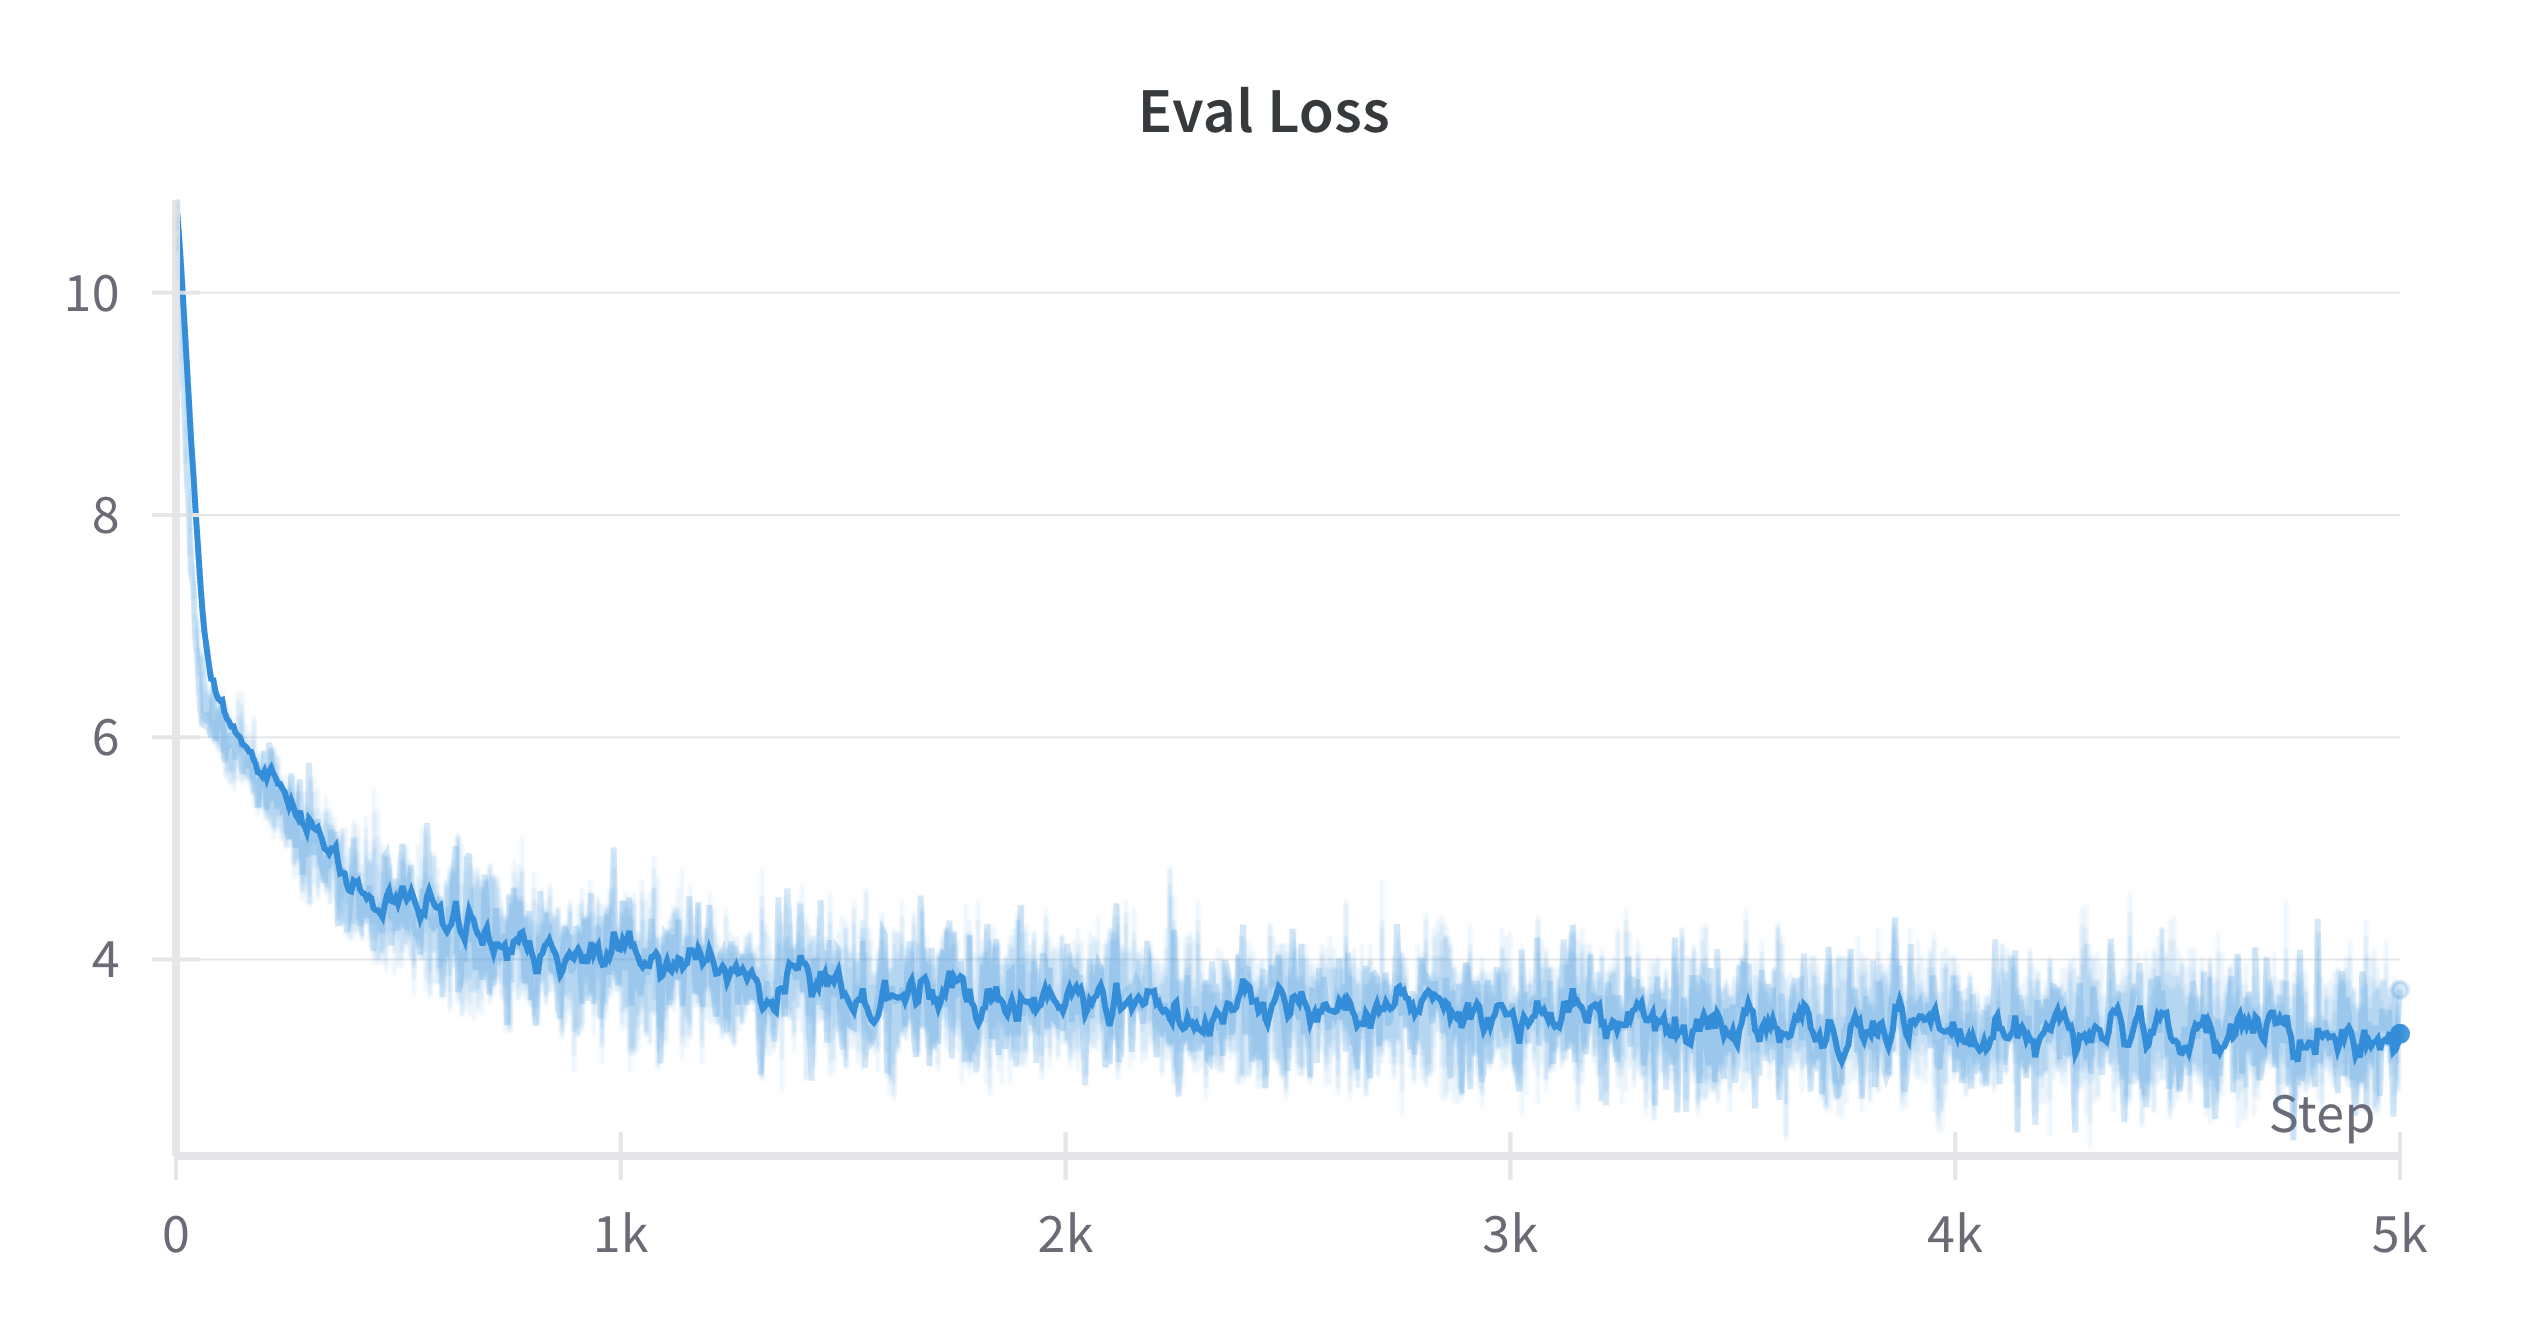

In [25]:
from IPython.display import Image, display
import os

img_path = os.path.join('.', 'Images', 'minigpt2_eval_loss.png')
display(Image(filename=img_path))

### Train and Valid Plots


** Show the training and validation loss plots **

### Generation (5 points)


Perform generation with the MiniGPT model that you trained. After that, copy over the generation function you used for the Bigram model and generate a mini story using the same seed sentence. 

    `"once upon a time"`

In [28]:
# TODO: Specify the path to your trained model
model_path = "./models/minigpt/mini_model_checkpoint_50000.pt"
model = MiniGPT(MiniGPTConfig)
tokenizer = tiktoken.get_encoding("gpt2")
model.load_state_dict(torch.load(model_path)["model_state_dict"])

/tmp/ipykernel_3001457/155155909.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)["model_state_dict"])


<All keys matched successfully>

In [61]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a little girl named Lily. She had a favorite doll named Rosie. Rosie was beautiful with white and blue eyes. One day, Lily went to a big party and saw all the toys perfect! She ordered Rosie with her one. 
Lily was so happy to see her doll, but then a bad boy named Max came. He grabbed Rosie and wouldn't give it back. "Give her back!" called Lily. "No, she's mine!" Max said. "You have spoiled Rosie!" 
Lily was sad and didn't know what to do. But then she had an idea. "I'm sorry," she said. "I doesn't mean to steal you." Max smiled. "That's okay," he said. "You are my friend and I'm happy to help you." From that day on, Lily played with Rosie and never picked a doll again.Once upon a time, there was a


Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence?
   Overall it is fine, because it exists few grammar errors and the coherence is reasonable but not attractive. 
3. If the model is scaled with more parameters do you expect the GPT model to get substantially better? Why or why not?
   I think so. Because the dataset is so huge, it has 1515490 items. When we train the current model, the loss consistently decreases until it reaches a plateau (loss is about 3.2). We can tell that the capability of current model is limited. We further searched online which says current LLM often arrives at 1~2, so we still have a distance to that but the network cannot decrease further. 

### Scaling up the model (5 points)

To show that scale indeed will help the model learn we have trained a scaled up version of the model you just implemented. We will load the weights of this model and generate a mini story using the same seed sentence. Note that if you have implemented the model correctly just scaling the parameters and adding a few bells and whistles to the training script will results in a model like the one we will load now. 

In [62]:
from model import MiniGPT
from config import MiniGPTConfig

In [63]:
path_to_trained_model = "pretrained_models/best_train_loss_checkpoint.pth"

In [64]:
ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if using GPU

/tmp/ipykernel_3001457/2544158094.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if 

In [65]:
# Set the configs for scaled model 
MiniGPTConfig.context_length = 512
MiniGPTConfig.embed_dim = 256
MiniGPTConfig.num_heads = 16
MiniGPTConfig.num_layers = 8

In [66]:
# Load model from checkpoint
model = MiniGPT(MiniGPTConfig)
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [67]:
tokenizer = tiktoken.get_encoding("gpt2")

In [68]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a little boy named Tim. Tim loved to swing on the trees and watch the birds fly in the sky. One day, Tim heard a swing in the park. He was eager to swing on the swing, but it was too big for him. He told his mom, "I want to go on the swing, but it's too hard for me."
His mom said, "If you help me fix the swing, the swing will float away." Tim was excited and helped his mom fix the swing. After all the swings were fixed, Tim took it to the park. He started to swing back and forth, higher and higher.
After a while, a nice lady came to the park. She saw Tim on the swing and said, "Wow, you found my swing! I wish I could float on it too." Tim was happy to help and said, "Thank you! Do you want to come to my park and play with me?"


## Bonus (5 points)

The following are some open ended questions that you can attempt if you have time. Feel free to propose your own as well if you have an interesting idea. 

1. The model we have implemented is a decoder only model. Can you implement the encoder part as well? This should not be too hard to do since most of the layers are already implemented.
2. What are some improvements we can add to the training script to make training more efficient and faster? Can you concretely show that the improvements you made help in training the model better?
3. Can you implement a beam search decoder to generate the text instead of greedy decoding? Does this help in generating better text?
4. Can you further optimize the model architecture? For example, can you implement [Multi Query Attention](https://arxiv.org/abs/1911.02150) or [Grouped Query Attention](https://arxiv.org/pdf/2305.13245) to improve the model performance?